In [1]:
from matplotlib import pyplot as plt
%matplotlib inline

## Boilerplate needed for notebooks

In [2]:
run_dir = "../results/TransOp_smart-deluge-130/"
current_checkpoint = 250
device_idx = [0]

In [3]:
import sys
import os 
import math
sys.path.append(os.path.dirname(os.getcwd()) + "/src/")

import numpy as np
import torch
from omegaconf import OmegaConf
import omegaconf

from eval.utils import encode_features
from model.model import Model
from model.config import ModelConfig
from experiment import ExperimentConfig
from dataloader.contrastive_dataloader import get_dataloader
from dataloader.utils import get_unaugmented_dataloader

# Set the default device
default_device = torch.device("cuda:0")
# Load config
cfg = omegaconf.OmegaConf.load(run_dir + ".hydra/config.yaml")
# Load model
default_model_cfg = ModelConfig()
model = Model.initialize_model(cfg.model_cfg, device_idx)
state_dict = torch.load(run_dir + f"checkpoints/checkpoint_epoch{current_checkpoint}.pt")
model.load_state_dict(state_dict['model_state'])
# Manually override directory for dataloaders
cfg.train_dataloader_cfg.dataset_cfg.dataset_dir = "../datasets"
cfg.train_dataloader_cfg.batch_size = 32
cfg.eval_dataloader_cfg.dataset_cfg.dataset_dir = "../datasets"
# Load dataloaders
train_dataset, train_dataloader = get_dataloader(cfg.train_dataloader_cfg)
eval_dataset, eval_dataloader = get_dataloader(cfg.eval_dataloader_cfg)
unaugmented_train_dataloader = get_unaugmented_dataloader(train_dataloader)
# Get encoding of entire dataset
train_eval_input = encode_features(model, unaugmented_train_dataloader, default_device)
# Load transport operators
psi = model.contrastive_header.transop_header.transop.get_psi()

Using cache found in /home/kion/.cache/torch/hub/pytorch_vision_v0.10.0
/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/kion/anaconda3/envs/simclr/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
coeff_list = []
z0 = []
z1 = []
z1_hat = []

for idx, batch in enumerate(train_dataloader):
    x_list = list(batch[0])
    # Tensor of input images of shape [B x V x H x W x C]
    x_gpu = torch.stack([x.to(default_device) for x in x_list]).transpose(0, 1)
    x_idx = torch.Tensor([int(idx) for idx in batch[2]])

    model_output = model(x_gpu, x_idx)
    coeff_list.append(model_output.distribution_data.samples.detach().cpu().numpy())
    z0.append(model_output.feature_0.detach().cpu().numpy())
    z1.append(model_output.feature_1.detach().cpu().numpy())
    z1_hat.append(model_output.prediction_1.detach().cpu().numpy())

    #loss_metadata, total_loss = model.compute_loss(model_output)


/home/kion/manifold-contrastive/src/model/manifold/transop.py:18: UserWarning: An output with one or more elements was resized since it had shape [1, 512, 512], which does not match the required output shape [1, 1, 512, 512]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  out = torch.matrix_exp(T) @ x
/home/kion/manifold-contrastive/src/model/manifold/transop.py:18: UserWarning: An output with one or more elements was resized since it had shape [2, 512, 512], which does not match the required output shape [1, 2, 512, 512]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Tri

Text(0.5, 1.0, 'Transport Operator Index')

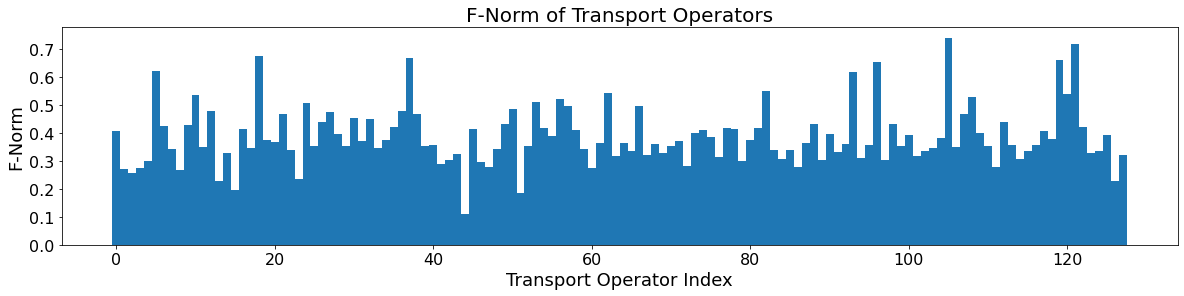

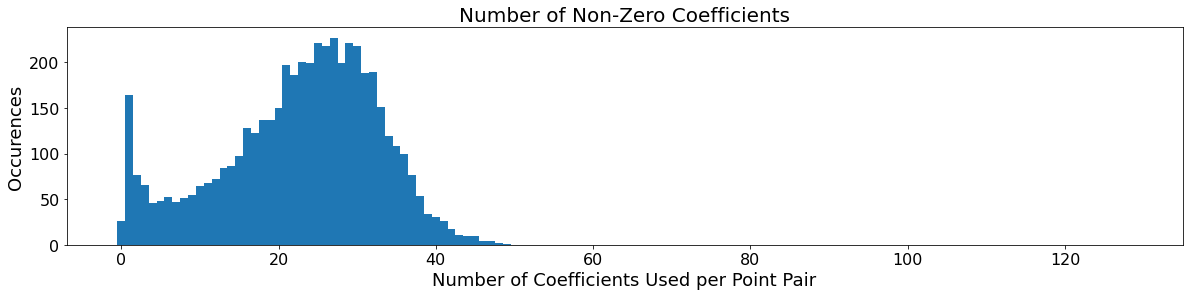

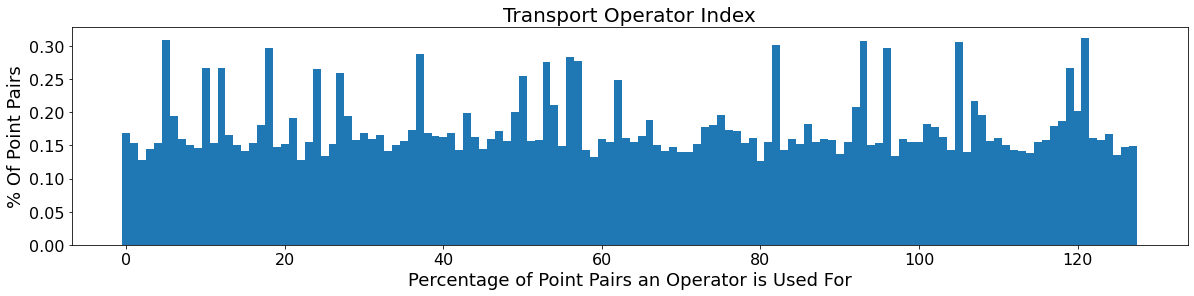

In [5]:
mini_coeff_list = np.concatenate(coeff_list)[:5000]
count_nz = np.zeros(len(psi) + 1, dtype=int)
coeff_nz = np.count_nonzero(mini_coeff_list, axis=0)
total_nz = np.count_nonzero(mini_coeff_list, axis=1)
for z in range(len(total_nz)):
    count_nz[total_nz[z]] += 1
number_operator_uses = np.count_nonzero(mini_coeff_list, axis=0) / len(mini_coeff_list)

transop_norms = ((psi.reshape(len(psi), -1))**2).sum(dim=-1).detach().cpu().numpy()
fig = plt.figure(figsize=(20, 4))
plt.bar(np.arange(len(transop_norms)), transop_norms, width=1)
plt.xlabel("Transport Operator Index", fontsize=18)
plt.ylabel("F-Norm", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("F-Norm of Transport Operators", fontsize=20)

fig = plt.figure(figsize=(20, 4))
plt.bar(np.arange(len(transop_norms) + 1), count_nz, width=1)
plt.xlabel("Number of Coefficients Used per Point Pair", fontsize=18)
plt.ylabel("Occurences", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Number of Non-Zero Coefficients", fontsize=20)

fig = plt.figure(figsize=(20, 4))
plt.bar(np.arange(len(transop_norms)), number_operator_uses, width=1)
plt.xlabel("Percentage of Point Pairs an Operator is Used For", fontsize=18)
plt.ylabel("% Of Point Pairs", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title("Transport Operator Index", fontsize=20)

IndexError: index 128 is out of bounds for axis 1 with size 128

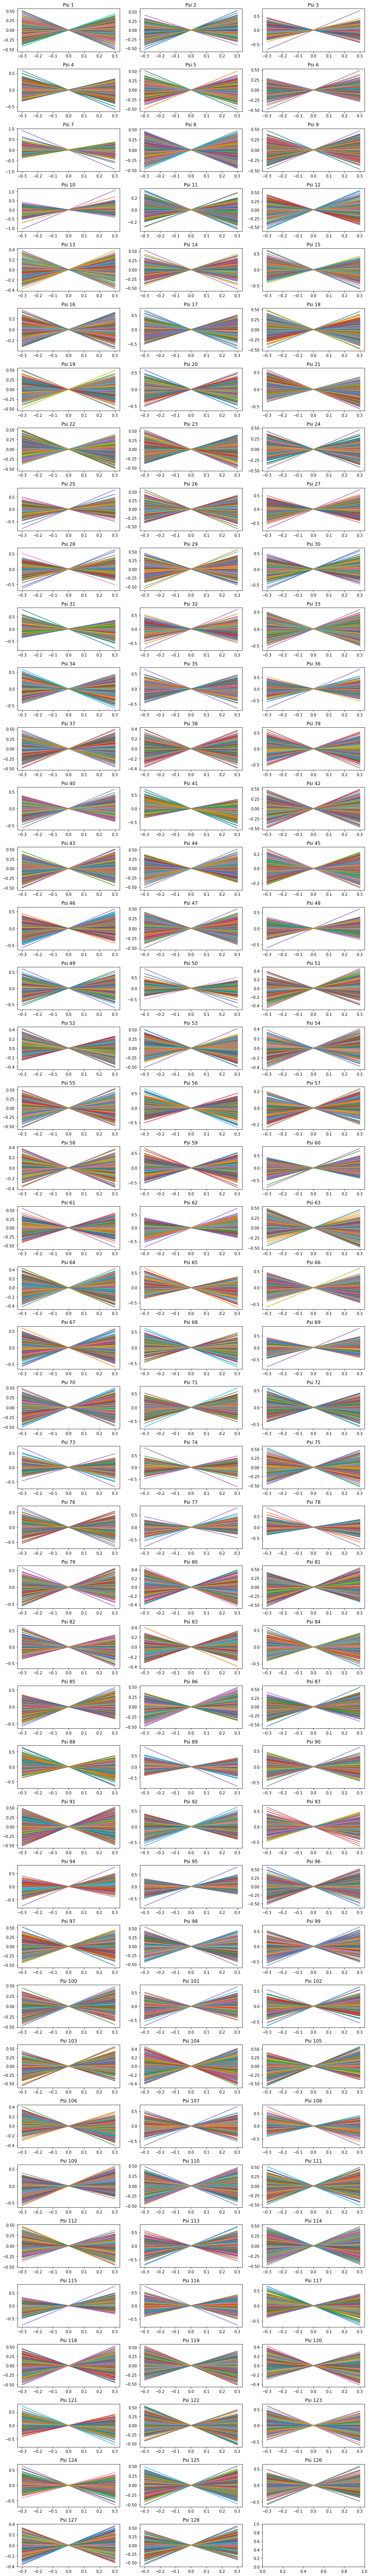

In [6]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

coeff_range = 0.3
train_example = 5
num_steps = 20

z = torch.tensor(np.concatenate(z0)[train_example]).unsqueeze(-1).to('cuda:0')
coeff_interp = np.linspace(-coeff_range, coeff_range, 100)
psi = model.contrastive_header.transop_header.transop.psi
dict_size = len(psi)
latent_dim = len(z)

fig, ax = plt.subplots(nrows=len(psi)//3 + 1, ncols=3, figsize=(16, 118))
plt.subplots_adjust(hspace=0.4, top=.9)
curr_psi = 0

for i in range(ax.size):
    row = int(i / 3)
    column = int(i % 3)
    
    coeff_interp = np.zeros((20, dict_size))
    coeff_interp[:, curr_psi] = np.linspace(-coeff_range, coeff_range, num_steps)

    coeff = torch.tensor(coeff_interp).float().to('cuda:0')
    T = torch.einsum("bm,mpk->bpk", coeff, psi)
    z1_hat = (T @ z).squeeze(dim=-1)

    #reg = LinearRegression().fit(coeff_interp[:, None], z_path.detach().cpu().numpy())
    #score = reg.score(coeff_interp[:, None], z_path.detach().cpu().numpy())
    
    for z_dim in range(latent_dim):
        ax[row, column].plot(np.linspace(-coeff_range, coeff_range, num_steps), 
                             z1_hat[:, z_dim].detach().cpu().numpy())
        ax[row, column].title.set_text(f'Psi {i+1}')
    
    curr_psi += 1
#fig.suptitle("Latent Dim Path for Coefficient Sweep from (-{}, {})    Z={}".format(coeff_range, coeff_range, latent_dim))    
print()

Text(0.5, 1.0, 'Log Singular Values for Operators')

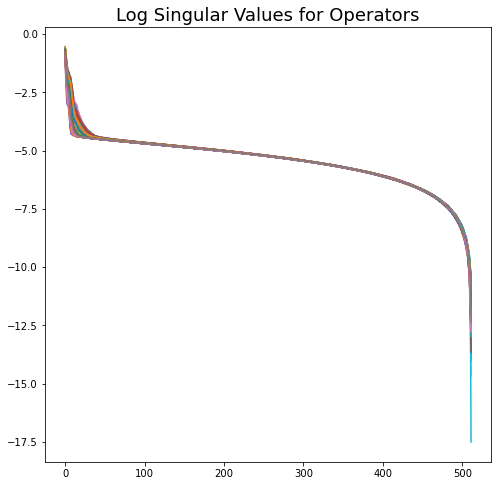

In [7]:
plt.figure(figsize=(8,8))
for operator in psi:
    u, s, vt = np.linalg.svd(operator.detach().cpu().numpy())
    plt.plot(np.log(s))
plt.title("Log Singular Values for Operators", fontsize=18)

Text(0.5, 1.0, 'Real (solid) and Imaginary (dashed)\n Eigenvalues for Operators')

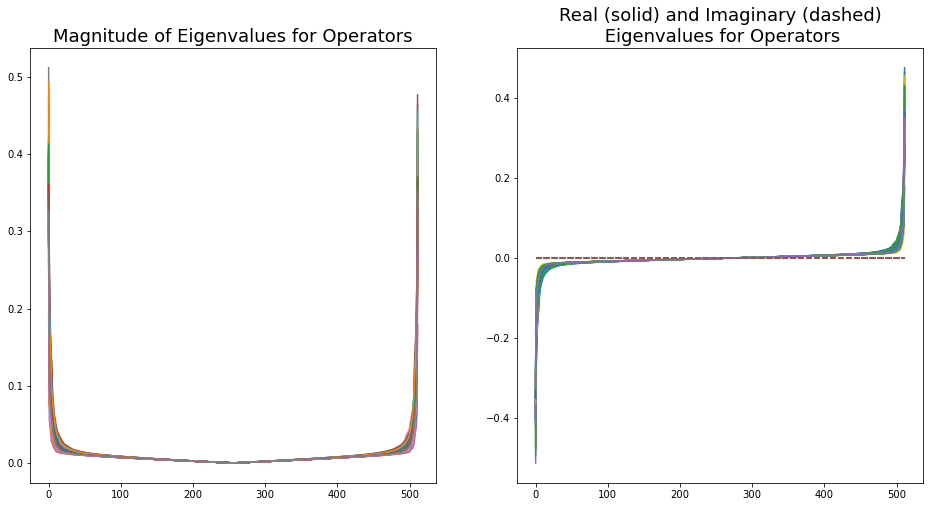

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
for operator in psi:
    w, v = np.linalg.eigh(operator.detach().cpu().numpy())
    ax[0].plot(np.absolute(w))
    
    ax[1].plot(w.real)
    ax[1].plot(w.imag, linestyle='--')
ax[0].set_title("Magnitude of Eigenvalues for Operators", fontsize=18)
ax[1].set_title("Real (solid) and Imaginary (dashed)\n Eigenvalues for Operators", fontsize=18)


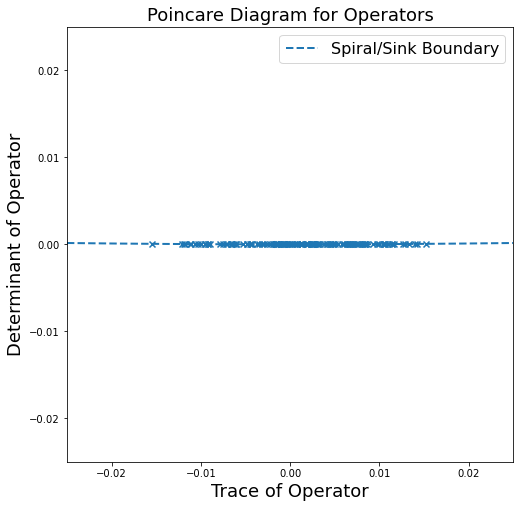

In [12]:
scale = 0.025

parabola_x = np.linspace(-1 * scale, 1 * scale, 10)
parabola_y = 0.25 * (parabola_x ** 2)

plt.figure(figsize=(8,8))
trace = np.trace(psi.detach().cpu().numpy(), axis1=1, axis2=2)
det = np.linalg.det(psi.detach().cpu().numpy())

plt.scatter(trace, det, marker="x")
plt.plot(parabola_x, parabola_y, label="Spiral/Sink Boundary", linestyle='--', linewidth=2)
plt.xlabel("Trace of Operator", fontsize=18)
plt.ylabel("Determinant of Operator", fontsize=18)
plt.title("Poincare Diagram for Operators", fontsize=18)
plt.xlim([-1 * scale, 1 * scale])
plt.ylim([-1 * scale, 1 * scale])
plt.legend(fontsize=16)

Text(0, 0.5, 'Angle (Degrees)')

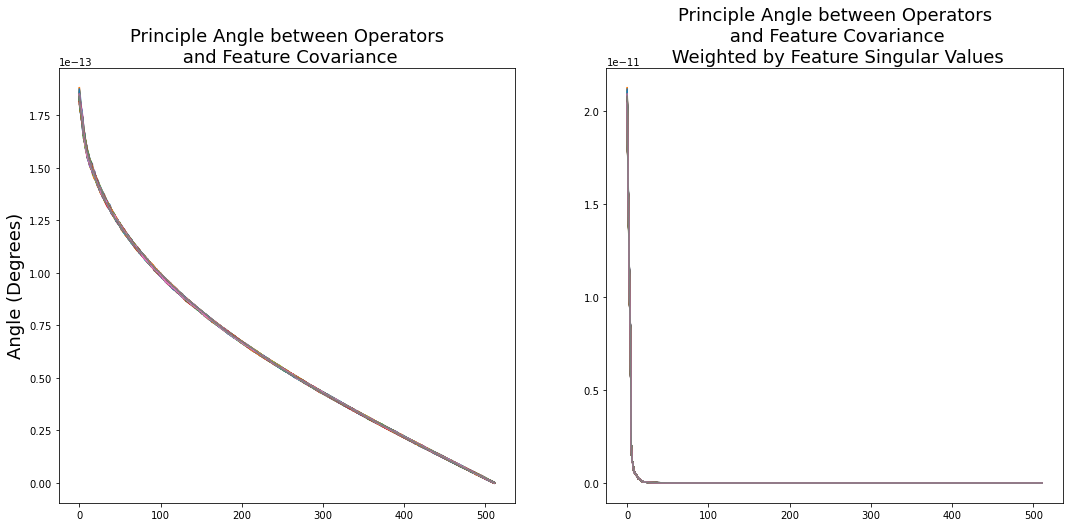

In [11]:
from scipy.linalg import subspace_angles

z = np.concatenate(z0)
z_cov = np.cov(z.T)
u_z, s_z, vt_z = np.linalg.svd(z_cov)
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

for operator in psi:
    u, s, vt = np.linalg.svd(operator.detach().cpu().numpy())
    sangles = np.rad2deg(subspace_angles(vt_z, vt))
    ax[0].plot(sangles)
    ax[1].plot(sangles * s_z)
ax[0].set_title("Principle Angle between Operators\n and Feature Covariance", fontsize=18)
ax[1].set_title("Principle Angle between Operators\n and Feature Covariance\n Weighted by Feature Singular Values", fontsize=18)
ax[0].set_ylabel("Angle (Degrees)", fontsize=18)